In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize

#needs blpapi to be installed
import pdblp

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

### Query data from Bloomberg

In [3]:
con = pdblp.BCon(port=8194)
con.start()

# bloomberg indices
historical_tickers = [
    'G0O1 Index',
    'LUATTRUU Index',
    'LBUTTRUU Index',
    'BCOMTR Index',
    'SPX Index',
    'BCOMGCTR Index',
    'JPEIGLBL Index',
    'LF98TRUU Index',
    'LT08TRUU Index'
]

names = [
    'RF',
    'US Tsy',
    'US Tips',
    'Commodities',
    'US Equities',
    'Gold',
    'EM Bonds',
    'HY Bonds',
    'Intermediate US Tsy'
]

flds = ['PX_LAST']
startDate = 19701231
rdf = con.bdh(historical_tickers, flds, startDate, '')

# remove multiindex
rdf.columns = rdf.columns.droplevel(1)
rdf = rdf.rename(columns=dict(zip(historical_tickers,names)))

# convert to monthly
rdf = rdf.resample('M').last()

# % change
rdf = rdf.pct_change()

con.stop()
rdf.tail()

ticker,Intermediate US Tsy,RF,US Tsy,US Tips,Commodities,US Equities,Gold,EM Bonds,HY Bonds
date,,,,,,,,,
2018-01-31,-0.009758,0.001193,-0.013584,-0.008574,0.019859,0.056179,0.023434,-0.001956,0.005995
2018-02-28,-0.002999,0.000946,-0.007534,-0.009719,-0.017295,-0.038947,-0.017578,-0.019594,-0.008498
2018-03-31,0.005320,0.001402,0.009430,0.010505,-0.006215,-0.026885,0.004056,0.003769,-0.006041
2018-04-30,-0.005799,0.001307,-0.008100,-0.000574,0.025845,0.002719,-0.004543,-0.014630,0.006507
2018-05-31,-0.002593,0.000971,-0.005215,-0.008215,0.013162,0.032469,-0.023165,-0.018838,0.000057


In [4]:
print("Start Dates")
for i,n in enumerate(names):
    null_mask = pd.isnull(rdf[n])
    print("%s : %s" % (n, str(rdf.loc[null_mask,n].index[-1].date())))

Start Dates
RF : 1977-12-31
US Tsy : 1973-01-31
US Tips : 1997-03-31
Commodities : 1991-01-31
US Equities : 1970-12-31
Gold : 1991-01-31
EM Bonds : 1993-12-31
HY Bonds : 1983-07-31
Intermediate US Tsy : 1973-01-31


### Growth & Inflation Data

In [5]:
gidf = pd.read_csv('macrodf.csv')
gidf = gidf.set_index('date')
gidf.head(15).tail(5)

,INDPRO,INDPRO Trend,dindprod3,INDPRO Monthly,INDPRO Quarterly,INDPRO Forecast Surprise,INDPRO Forecast Surprise Normalized,INDPRO Forecast Surprise Signal,INDPRO Trend Surprise,INDPRO Trend Surprise Normalized,...,CPURNSA Index Monthly,CPURNSA Index Quarterly,CPI Forecast Surprise,CPI Forecast Surprise Normalized,CPI Forecast Surprise Signal,CPI Trend Surprise,CPI Trend Surprise Normalized,CPI Trend Surprise Signal,CPI Combined Surprise Normalized,CPI Combined Surprise Signal
date,,,,,,,,,,,,,,,,,,,,,
1970-10-31,37.7154,NaN,0.048184,-0.215307,-0.014194,-0.062378,-1.039537,0.0,NaN,NaN,...,0.062972,0.062645,0.032685,0.988772,1.0,NaN,NaN,NaN,NaN,NaN
1970-11-30,37.4870,NaN,0.048184,-0.070298,-0.014194,-0.062378,-1.039537,0.0,NaN,NaN,...,0.062643,0.062645,0.032685,0.988772,1.0,NaN,NaN,NaN,NaN,NaN
1970-12-31,38.3479,NaN,0.048184,0.313200,-0.014194,-0.062378,-1.039537,0.0,NaN,NaN,...,0.062318,0.062645,0.032685,0.988772,1.0,NaN,NaN,NaN,NaN,NaN
1971-01-31,38.6429,-0.036150,0.154570,0.096320,0.018855,-0.135715,-2.261695,0.0,0.132470,1.545854,...,0.000000,0.020253,-0.016760,-0.507037,0.0,-0.055725,-1.417889,0.0,-0.962463,0.0
1971-02-28,38.5692,-0.010502,0.154570,-0.022648,0.018855,-0.135715,-2.261695,0.0,-0.012146,-0.141738,...,0.030571,0.020253,-0.016760,-0.507037,0.0,-0.022370,-0.569183,0.0,-0.538110,0.0


### Combine Growth and Inflation surprise data with monthly return data

In [6]:
rdf2 = pd.merge(
    rdf,
    gidf.loc[:,
             [
                 'INDPRO Forecast Surprise Signal',
                 'INDPRO Trend Surprise Signal',
                 'INDPRO Combined Surprise Signal',
                 'CPI Forecast Surprise Signal',
                 'CPI Trend Surprise Signal',
                 'CPI Combined Surprise Signal'
             ]
            ],
    how='left',
    left_index=True,
    right_index=True
)

# start at 73
start73_mask = rdf2.index >= pd.datetime(1973,1,1)

# end in 2017
end17_mask = rdf2.index <= pd.datetime(2017,12,31)

rdf2 = rdf2[(start73_mask & end17_mask)]
rdf2.head(12)

,Intermediate US Tsy,RF,US Tsy,US Tips,Commodities,US Equities,Gold,EM Bonds,HY Bonds,INDPRO Forecast Surprise Signal,INDPRO Trend Surprise Signal,INDPRO Combined Surprise Signal,CPI Forecast Surprise Signal,CPI Trend Surprise Signal,CPI Combined Surprise Signal
date,,,,,,,,,,,,,,,
1973-01-31,NaN,NaN,NaN,NaN,NaN,-0.017111,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,1.0
1973-02-28,-0.002728,NaN,-0.002627,NaN,NaN,-0.037490,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0
1973-03-31,-0.000101,NaN,0.000000,NaN,NaN,-0.001433,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0
1973-04-30,0.009422,NaN,0.009420,NaN,NaN,-0.040800,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0
1973-05-31,0.002609,NaN,0.002208,NaN,NaN,-0.018884,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0
1973-06-30,0.002803,NaN,0.002703,NaN,NaN,-0.006575,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0
1973-07-31,-0.020463,NaN,-0.021068,NaN,NaN,0.037982,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,1.0
1973-08-31,0.019260,NaN,0.019584,NaN,NaN,-0.036685,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0
1973-09-30,0.021196,NaN,0.022009,NaN,NaN,0.040096,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0


In [7]:
# convert to spread indices to remove Tsy component
rdf2['HY Spread'] = rdf2['HY Bonds'] - rdf2['Intermediate US Tsy']
rdf2['EM Spread'] = rdf2['EM Bonds'] - rdf2['Intermediate US Tsy']

In [8]:
signal_cols_dict = {
    'Forecast' : ('INDPRO Forecast Surprise Signal','CPI Forecast Surprise Signal'),
    'Trend' : ('INDPRO Trend Surprise Signal','CPI Trend Surprise Signal'),
    'Combined' : ('INDPRO Combined Surprise Signal','CPI Combined Surprise Signal')
}

cash_ticker = 'RF'

tickers = np.array(
    [
        'US Tsy',
        'US Tips',
        'US Equities',
        'Commodities',
        'Gold',
        'HY Spread',
        'EM Spread'
    ]
)

macro_environments = np.array([
                'All',
                'Growth Up',
                'Growth Down',
                'Inflation Up',
                'Inflation Down',
                'Growth Up + Inflation Up',
                'Growth Up + Inflation Down',
                'Growth Down + Inflation Up',
                'Growth Down + Inflation Down'
            ])

macro_envs_ordered = np.array([
    'Growth Down + Inflation Down',
    'Growth Up + Inflation Down',
    'Growth Down + Inflation Up',
    'Growth Up + Inflation Up'
])

In [9]:
def create_macro_environment_masks(
    rdf:pd.DataFrame,
    signal_type:str,
    sc_dict:dict=signal_cols_dict
) -> pd.DataFrame:
    
    mdf = pd.DataFrame(index=rdf.index)
    
    mdf['Growth Up'] = rdf[sc_dict[signal_type][0]] > 0.9
    mdf['Growth Down'] = rdf[sc_dict[signal_type][0]] < 0.1
    mdf['Inflation Up'] = rdf[sc_dict[signal_type][1]] > 0.9
    mdf['Inflation Down'] = rdf[sc_dict[signal_type][1]] < 0.1
    
    mdf['Growth Up + Inflation Up'] = mdf['Growth Up'] & mdf['Inflation Up']
    mdf['Growth Up + Inflation Down'] = mdf['Growth Up'] & mdf['Inflation Down']
    mdf['Growth Down + Inflation Up'] = mdf['Growth Down'] & mdf['Inflation Up']
    mdf['Growth Down + Inflation Down'] = mdf['Growth Down'] & mdf['Inflation Down']
    return mdf
    
def print_macro_environment_masks(mdf:pd.DataFrame) -> None:
    print("Rising Growth number of Months: %i" % np.nansum(mdf['Growth Up']))
    print("Rising Growth %% of Months: %.2f%%" % (np.nanmean(mdf['Growth Up'])*100))
    print("Falling Growth number of Months: %i" % np.nansum(mdf['Growth Down']))
    print("Falling Growth %% of Months: %.2f%%" % (np.nanmean(mdf['Growth Down'])*100))
    print("Rising Inflation number of Months: %i" % np.nansum(mdf['Inflation Up']))
    print("Rising Inflation %% of Months: %.2f%%" % (np.nanmean(mdf['Inflation Up'])*100))
    print("Falling Inflation number of Months: %i" % np.nansum(mdf['Inflation Down']))
    print("Falling Inflation %% of Months: %.2f%%" % (np.nanmean(mdf['Inflation Down'])*100))
    print("Rising Growth + Rising Inflation number of Months: %i" % np.nansum(mdf['Growth Up + Inflation Up']))
    print("Rising Growth + Rising Inflation %% of Months: %.2f%%" % (np.nanmean(mdf['Growth Up + Inflation Up'])*100))
    print("Rising Growth + Falling Inflation number of Months: %i" % np.nansum(mdf['Growth Up + Inflation Down']))
    print("Rising Growth + Falling Inflation %% of Months: %.2f%%" % (np.nanmean(mdf['Growth Up + Inflation Down'])*100))
    print("Falling Growth + Rising Inflation number of Months: %i" % np.nansum(mdf['Growth Down + Inflation Up']))
    print("Falling Growth + Rising Inflation %% of Months: %.2f%%" % (np.nanmean(mdf['Growth Down + Inflation Up'])*100))
    print("Falling Growth + Falling Inflation number of Months: %i" % np.nansum(mdf['Growth Down + Inflation Down']))
    print("Falling Growth + Falling Inflation %% of Months: %.2f%%" % (np.nanmean(mdf['Growth Down + Inflation Down'])*100))
    return

In [10]:
def calculate_sharpes_in_macro_envs(
    rdf:pd.DataFrame,
    mdf:pd.DataFrame,
    macro_environments:np.ndarray,
    tickers:np.ndarray,
    cash_ticker:str=cash_ticker) -> pd.DataFrame:
    
    resdf = pd.DataFrame(
        np.zeros((len(tickers),len(macro_environments))),
        index=tickers,
        columns=macro_environments
    )
    
    for t in tickers:
        #no need to subtract the risk free in self financing portfolios
        #this assumes going long HY and short duration matched treasuries is dollar neutral
        if t in ("HY Spread","EMD Spread"):
            for m in macro_environments:
                if m == 'All':
                    resdf.loc[t,m] = (
                        np.mean(rdf.loc[:,t])/np.std(rdf.loc[:,t],ddof=1)*np.sqrt(12)
                    )
                else:
                    mask = mdf[m]
                    resdf.loc[t,m] = (
                        np.mean(rdf.loc[mask,t])/np.std(rdf.loc[mask,t],ddof=1)*np.sqrt(12)
                    )
        else:
            for m in macro_environments:
                if m == 'All':
                    resdf.loc[t,m] = (
                        np.mean(rdf.loc[:,t] - rdf.loc[:,cash_ticker])/np.std(rdf.loc[:,t],ddof=1)*np.sqrt(12)
                    )
                else:
                    mask = mdf[m]
                    resdf.loc[t,m] = (
                        np.mean(rdf.loc[mask,t] - rdf.loc[mask,cash_ticker])/np.std(rdf.loc[mask,t])*np.sqrt(12)
                    )
    return resdf

## Examine Relationships with Macro Environments

In [11]:
signal_type = 'Forecast'
print(signal_type)

mdf_fc = create_macro_environment_masks(rdf2,signal_type,sc_dict=signal_cols_dict)
print_macro_environment_masks(mdf_fc)

signal_type = 'Trend'
print()
print(signal_type)

mdf_trend = create_macro_environment_masks(rdf2,signal_type,sc_dict=signal_cols_dict)
print_macro_environment_masks(mdf_trend)

signal_type = 'Combined'
print()
print(signal_type)

mdf_combined = create_macro_environment_masks(rdf2,signal_type,sc_dict=signal_cols_dict)
print_macro_environment_masks(mdf_combined)

Forecast
Rising Growth number of Months: 237
Rising Growth % of Months: 43.89%
Falling Growth number of Months: 303
Falling Growth % of Months: 56.11%
Rising Inflation number of Months: 276
Rising Inflation % of Months: 51.11%
Falling Inflation number of Months: 264
Falling Inflation % of Months: 48.89%
Rising Growth + Rising Inflation number of Months: 120
Rising Growth + Rising Inflation % of Months: 22.22%
Rising Growth + Falling Inflation number of Months: 117
Rising Growth + Falling Inflation % of Months: 21.67%
Falling Growth + Rising Inflation number of Months: 156
Falling Growth + Rising Inflation % of Months: 28.89%
Falling Growth + Falling Inflation number of Months: 147
Falling Growth + Falling Inflation % of Months: 27.22%

Trend
Rising Growth number of Months: 252
Rising Growth % of Months: 46.67%
Falling Growth number of Months: 288
Falling Growth % of Months: 53.33%
Rising Inflation number of Months: 268
Rising Inflation % of Months: 49.63%
Falling Inflation number of Mo

In [12]:
mdf_fc.head()

,Growth Up,Growth Down,Inflation Up,Inflation Down,Growth Up + Inflation Up,Growth Up + Inflation Down,Growth Down + Inflation Up,Growth Down + Inflation Down
date,,,,,,,,
1973-01-31,True,False,True,False,True,False,False,False
1973-02-28,True,False,True,False,True,False,False,False
1973-03-31,True,False,True,False,True,False,False,False
1973-04-30,False,True,True,False,False,False,True,False
1973-05-31,False,True,True,False,False,False,True,False


In [13]:
sdf_fc = calculate_sharpes_in_macro_envs(
    rdf2,
    mdf_fc,
    macro_environments,
    tickers,
    cash_ticker
)
print("Sharpes using Forecasts to determine economic surprises")
sdf_fc

Sharpes using Forecasts to determine economic surprises


,All,Growth Up,Growth Down,Inflation Up,Inflation Down,Growth Up + Inflation Up,Growth Up + Inflation Down,Growth Down + Inflation Up,Growth Down + Inflation Down
US Tsy,0.428411,-0.276634,0.940399,-0.156826,1.030702,-0.982884,0.484535,0.452903,1.424215
US Tips,0.595969,0.705667,0.572841,1.069588,0.186962,0.971618,0.460933,1.112372,0.105828
US Equities,0.304351,0.511230,0.147766,0.015521,0.574599,0.218235,0.769161,-0.128623,0.418800
Commodities,0.048434,0.194872,-0.031662,0.925863,-0.600812,1.030526,-0.351639,0.889166,-0.776800
Gold,0.196202,-0.174944,0.390413,0.580769,-0.105153,0.143741,-0.394584,0.796812,0.049177
HY Spread,0.331534,0.688105,0.171084,0.511622,0.203242,0.678269,0.693559,0.450176,-0.037417
EM Spread,0.216728,0.244905,0.195162,0.316077,0.156891,0.279363,0.228962,0.362533,0.073793


In [14]:
sdf_trend = calculate_sharpes_in_macro_envs(
    rdf2,
    mdf_trend,
    macro_environments,
    tickers,
    cash_ticker
)
print("Sharpes using Trend to determine economic surprises")
sdf_trend

Sharpes using Trend to determine economic surprises


,All,Growth Up,Growth Down,Inflation Up,Inflation Down,Growth Up + Inflation Up,Growth Up + Inflation Down,Growth Down + Inflation Up,Growth Down + Inflation Down
US Tsy,0.428411,-0.100160,0.859618,-0.031529,0.824133,-0.252020,0.047373,0.174401,1.426359
US Tips,0.595969,0.401801,0.800803,0.962579,0.246374,1.241037,-0.372439,0.706317,0.902686
US Equities,0.304351,0.140430,0.455854,0.162900,0.442510,0.080633,0.195189,0.233819,0.685456
Commodities,0.048434,0.137757,-0.028761,0.755240,-0.506968,1.095019,-0.664461,0.448225,-0.384186
Gold,0.196202,-0.048362,0.439289,0.536803,-0.127869,0.445372,-0.545549,0.631512,0.262990
HY Spread,0.331534,0.563227,0.116501,0.540625,0.154165,0.977317,0.224357,0.150136,0.087395
EM Spread,0.216728,0.002605,0.508284,0.316253,0.136026,0.042996,-0.025483,0.592885,0.413677


In [15]:
sdf_combined = calculate_sharpes_in_macro_envs(
    rdf2,
    mdf_combined,
    macro_environments,
    tickers,
    cash_ticker
)
print("Sharpes using a combination of Forecasts and Trend to determine economic surprises")
sdf_combined

Sharpes using a combination of Forecasts and Trend to determine economic surprises


,All,Growth Up,Growth Down,Inflation Up,Inflation Down,Growth Up + Inflation Up,Growth Up + Inflation Down,Growth Down + Inflation Up,Growth Down + Inflation Down
US Tsy,0.428411,-0.135346,0.823677,-0.072197,0.978017,-0.325796,0.085622,0.110760,1.622403
US Tips,0.595969,0.689787,0.532564,0.837444,0.355454,1.618555,0.013132,0.433800,0.656463
US Equities,0.304351,0.352841,0.265347,0.055174,0.550827,0.188578,0.489301,-0.034866,0.614393
Commodities,0.048434,0.240848,-0.093127,0.830841,-0.546165,1.348310,-0.475653,0.512922,-0.604825
Gold,0.196202,-0.038453,0.379596,0.572473,-0.124419,0.457593,-0.368321,0.645444,0.105501
HY Spread,0.331534,0.484982,0.228030,0.478278,0.207099,0.806551,0.274630,0.304262,0.152295
EM Spread,0.216728,0.098410,0.360033,0.273928,0.177846,0.459710,-0.091158,0.142610,0.619010


##### Differences between macroenvironments based on forecasts and macroenvironments based on trend:
* The relationship between equities growth is positive as expected when using forecasts but the relationship is negative when using trend to determine economic surprises.
* The relationship between EMD and growth is positive as expected when using forecasts but the relationship is negative when using trend.
* These observations are similar to what we saw when using the US indices.

This is one piece of information that leads me to like forecasts over trend to determine economic surprises but it isn't strong evidence.

##### Looking at the performance for each asset class in different macroenvironments:

* Global Treasuries - LGTRTRUH - performs well in Growth Down and Inflation Down
* Global Linkers - LF94TRUH - performs well in Growth Down. Global Linkers don't seem to have a strong relationship with Inflation. Inflation down is higher than Inflation Up but economic theory is less supportive of this result. You could reason that inflation protection is in more demand when inflation is rising but it isn't showing up with this definition of inflation surprise data.
* Global Equities - WHANWIHD - performs well in Growth Up and Inflation Down

The rest of the observations are the same.

* Commodities - BCOMTR - performs well in Growth Up and Inflation Up. The relationship between Growth and commodities is weaker. The economic theory would suggest that the demand increases from increasing growth would be a slow process therefore the relationship should not be strong. The variance caused by changes in the supply of money should be larger than the variance attributed to changes in growth. Even when we used trend to define inflation & growth expectations, there is a weak relationship.
* Gold - BCOMGCTR - performs well in Growth Down and Inflation Up. You would expect Gold to perform well in falling growth and rising inflation. When growth falls gold acts as a store of value. When inflation rises the value of gold relative currencies should increases because the value of the underlying currency is falling. 
* High Yield - HY Spread(long a High Yield bond index and short a duration matched treasury index) - performs well in growth up environments. The relationship with inflation in the data is positive but the economic theory behind the relationship suggests it should be negative if it is only disinflation.
* Emerging Market Debt - EMD Spread(long a USD denominated emerging market debt index and short a duration matched treasury index) - performs well in a inflation up environment. Theory indicates that EMD should perform well in both growth up and inflation up environments. My results vary depending on whether you use trend to determine economic surprises or if you use forecasts to determine economic surprises. When using forecasts to determine economic surprises, EMD performs well in both rising growth and rising inflation as expected. When using trend to determine economic surprises, rising inflation is a good environment for EMD but rising growth is a bad environment.

In [18]:
def plot_sharpes_across_macroenvironments(
    resdf:pd.DataFrame,
    macroenvironments:list,
    type_of_macro_forecast=None
):
    colors = ['blue','gray','red','orange','gold','purple','pink']
    for i,t in enumerate(resdf.index):
        plt.scatter(
            macroenvironments,
            resdf.loc[t,macroenvironments],
            label=t,
            color=colors[i]
        )
        plt.axhline(y=resdf.loc[t,'All'],color=colors[i])
    plt.axhline(y=0,color='gray',linestyle='dashed')
    plt.title("Sharpes Across Macroenvironments")
    plt.legend()
    
    if type_of_macro_forecast is not None:
        plt.annotate(
            "*Macroenvironment Surprises calculated using %s" % type_of_macro_forecast,
            (0, 0),
            (0, -40),
            xycoords='axes fraction',
            textcoords='offset points',
            va='top'
        )
    
    plt.show()

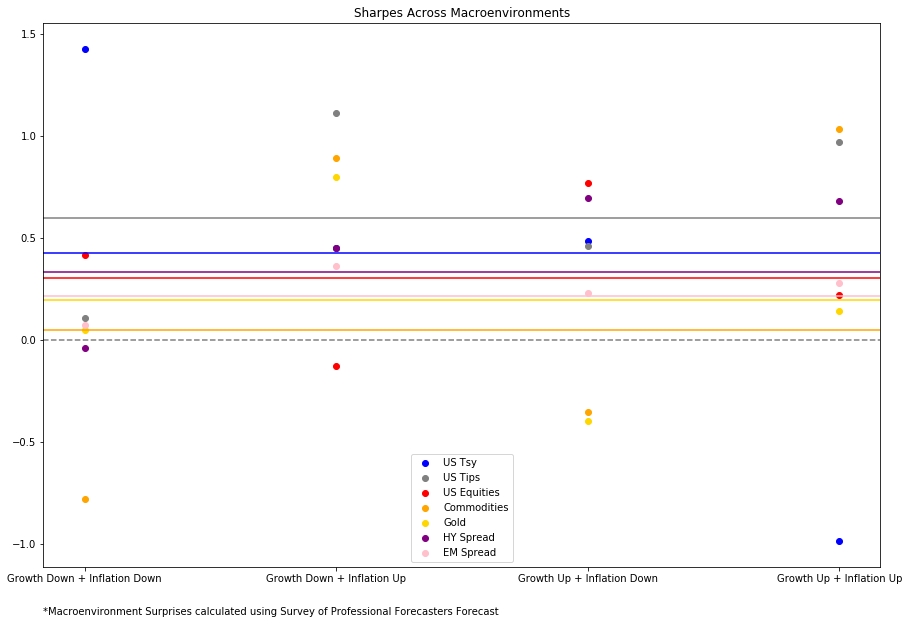

In [19]:
plot_sharpes_across_macroenvironments(
    sdf_fc,
    macro_environments[5:9],
    "Survey of Professional Forecasters Forecast"
)

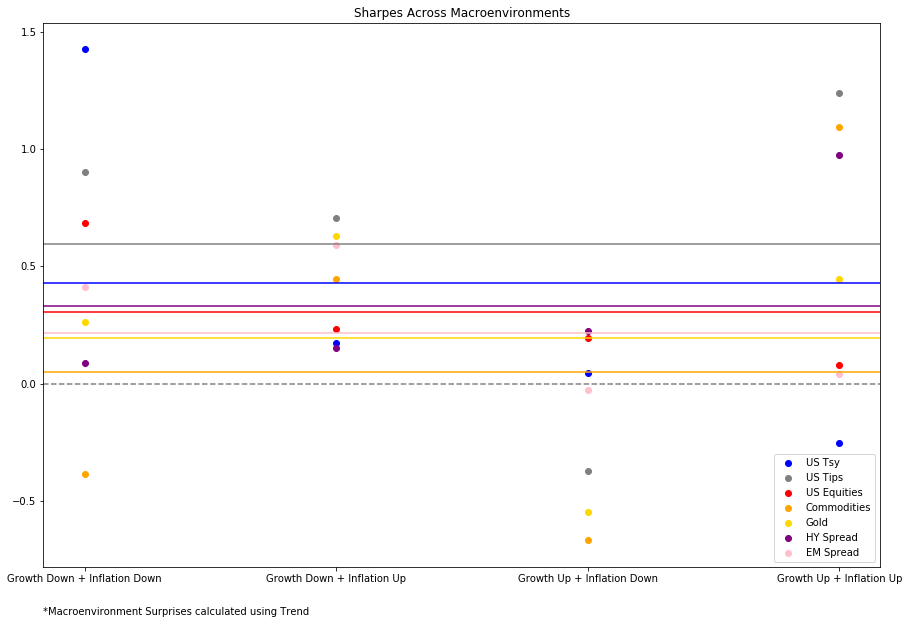

In [20]:
plot_sharpes_across_macroenvironments(
    sdf_trend,
    macro_environments[5:9],
    "Trend"
)

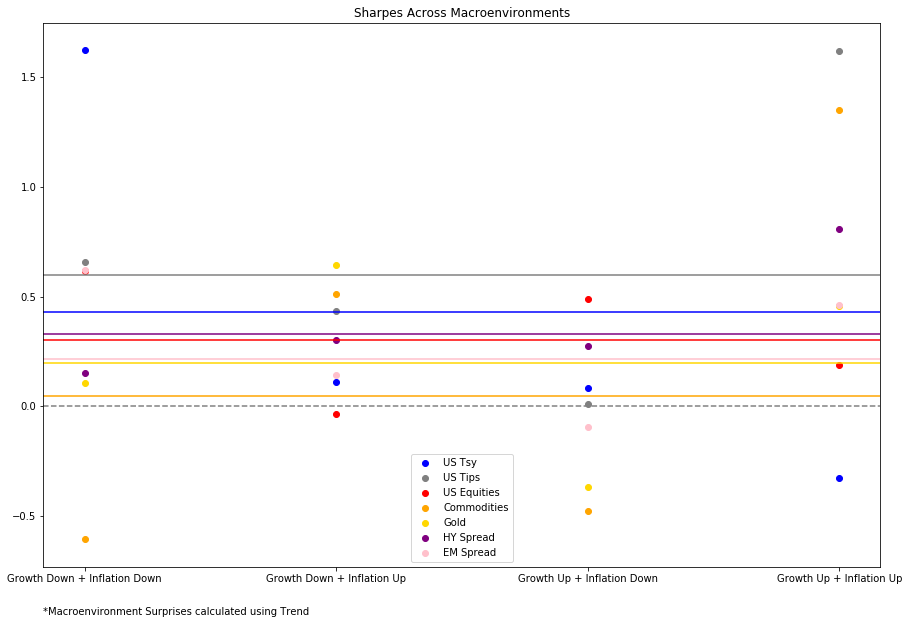

In [21]:
plot_sharpes_across_macroenvironments(
    sdf_combined,
    macro_environments[5:9],
    "Trend"
)